# Cell marginals to weight differential gene expression

This notebook shows how to use cell marginals, collected during the equilibration of the markov chain, as additional covariates in finding marker genes for each cluster. Cell marginals are the posterior probabilities of the inferred model, in lean terms they measure the uncertainity for a cell to belong to a specific group.
This demonstration is performed on 3k PBMC available from 10x datasets. Note that the preprocessing is copied from [scanpy's tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)

In [1]:
import scanpy as sc
import scnsbm
import pandas as pd
%pylab
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import anndata
import statsmodels.api as sm

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


filtered out 19024 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:02)
extracting highly variable genes
    finished (0:00:00)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:01)


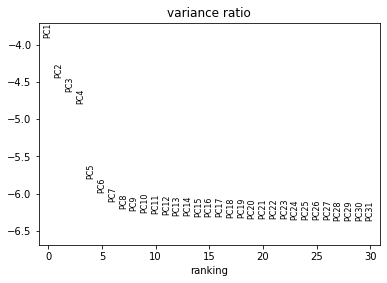

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:03)
computing UMAP
    finished (0:00:04)
running Leiden clustering
    finished (0:00:00)


In [2]:
adata = sc.datasets.pbmc3k()

sc.settings.verbosity=2

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1


adata = adata[adata.obs.n_genes < 2500, :]
adata = adata[adata.obs.percent_mito < 0.05, :]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.raw = adata

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

adata = adata[:, adata.var.highly_variable]

sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='arpack')

sc.pl.pca_variance_ratio(adata, log=True)

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

sc.tl.umap(adata)
sc.tl.leiden(adata)

Once data have been processed, we run the inference for the nested model. Here we also collect cell marginals. This option needs to be specified as, by default, is set to `False`. By default it forces an additional equilibration step for a fixed number of iterations (10,000). It requires significantly more time to run.

In [3]:
scnsbm.inference.nested_model(adata, random_seed=1024, epsilon=1e-3, collect_marginals=True)

minimizing the nested Stochastic Block Model
MCMC equilibration
    done (0:10:25)
    collecting marginals
    done (0:33:17)
    finished (0:33:18)


In [6]:
adata.write("pbcm3k_nested_simple.h5ad")

We focus on level 2 of NSBM hierarchy, which closely recapitulates the one in the tutorials. Yet we found some additional small group.

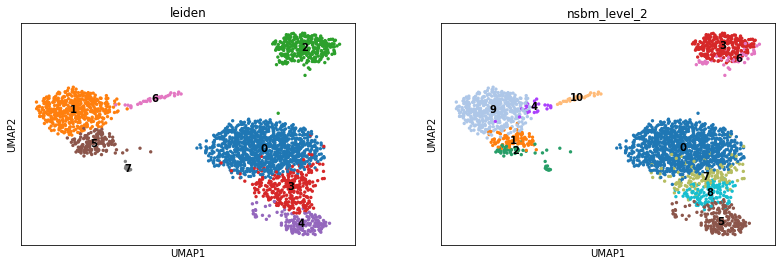

In [9]:
sc.pl.umap(adata, color=['leiden', 'nsbm_level_2'], legend_loc='on data')

`adata.uns` contains a slot for cell marginals, it is a dictionary in which each key is a level (including level 0). Data are counts, so it need to be normalized to 1

In [10]:
marginals = adata.uns['nsbm']['cell_marginals'][2] 
marginals = marginals / np.sum(marginals, axis=1).max() #marginals are counts, normalize by their sum (collect_niter)

We use here a generalized linear model (GLM) from `pystatsmodels`. In order to perform a comparison, we build a model in which covariates are groups definition and a weighted model in which covariates are cell marginals. In the end we will add two slots to `adata.uns` built over the template for `rank_genes_groups`. Note, however, that fold changes are the coefficients of the GLM, and they are not calculated as in default t-test. When t-test is performed each group is compared to the remaining cells, here instead coefficients should be interpreted as fold changes for a group corrected for all the other covariates.

In [11]:
groups = sm.tools.categorical(data = adata.obs, col='nsbm_level_2', drop=True) #convert to dummy variables

In [12]:
expr_values = adata.X #get expression data from the matrix

In [13]:
flat_model = [sm.GLM(expr_values[:, x], sm.add_constant(groups)) for x in range(expr_values.shape[1])]
flat_results = [x.fit() for x in flat_model]

In [14]:
flat_scores = np.array([x.params[1:] for x in flat_results])
flat_pvals = np.array([x.pvalues[1:] for x in flat_results])
flat_fdr = np.array([sm.stats.multipletests(flat_pvals[:, x], method='fdr_bh')[1] for x in range(flat_pvals.shape[1])]).T

In [15]:
gene_names = []
gene_scores = []
gene_pvalues = []
gene_fdr = []
gene_foldchange = []
for x in range(flat_scores.shape[1]):
    up_mask = flat_scores[:, x] > 0
    scores = flat_scores[up_mask, x]
    pvals = flat_pvals[up_mask, x]
    genes = np.array(adata.var_names)[up_mask]
    fdr = flat_fdr[up_mask, x]
    selected = np.argsort(fdr)[:100]
    order = np.argsort(scores[selected])[::-1]
    gene_names.append(genes[selected][order])
    gene_scores.append(scores[selected][order])
    gene_pvalues.append(pvals[selected][order])
    gene_fdr.append(fdr[selected][order])
    gene_foldchange.append(scores[selected][order])

In [16]:
adata.uns['flat_gene_glm'] = {
    'params': {'groupby': 'nsbm_level_2',
              'reference': 'rest',
              'method': 'GLM',
              'use_raw': False,
              'layer': None,
              'corr_method': 'benjamini-hochberg'},
    'scores': np.rec.fromarrays([n for n in gene_scores], dtype=[(rn, 'float32') for rn in adata.obs.nsbm_level_2.cat.categories]),
    'logfoldchanges': np.rec.fromarrays([n for n in gene_scores], dtype=[(rn, 'float32') for rn in adata.obs.nsbm_level_2.cat.categories]),    
    'pvals': np.rec.fromarrays([n for n in gene_pvalues], dtype=[(rn, 'float32') for rn in adata.obs.nsbm_level_2.cat.categories]),    
    'pvals_adj': np.rec.fromarrays([n for n in gene_fdr], dtype=[(rn, 'float32') for rn in adata.obs.nsbm_level_2.cat.categories]),        
    'names': np.rec.fromarrays([n for n in gene_names], dtype=[(rn, 'U50') for rn in adata.obs.nsbm_level_2.cat.categories]),        
}

In [17]:
weight_model = [sm.GLM(expr_values[:, x], sm.add_constant(marginals)) for x in range(expr_values.shape[1])]
weight_results = [x.fit() for x in weight_model]

In [18]:
weight_scores = np.array([x.params[1:] for x in weight_results])
weight_pvals = np.array([x.pvalues[1:] for x in weight_results])
weight_fdr = np.array([sm.stats.multipletests(weight_pvals[:, x], method='fdr_bh')[1] for x in range(weight_pvals.shape[1])]).T

In [19]:
gene_names = []
gene_scores = []
gene_pvalues = []
gene_fdr = []
gene_foldchange = []
for x in range(weight_scores.shape[1]):
    up_mask = weight_scores[:, x] > 0
    scores = weight_scores[up_mask, x]
    pvals = weight_pvals[up_mask, x]
    genes = np.array(adata.var_names)[up_mask]
    fdr = weight_fdr[up_mask, x]
    selected = np.argsort(fdr)[:100]
    order = np.argsort(scores[selected])[::-1]
    gene_names.append(genes[selected][order])
    gene_scores.append(scores[selected][order])
    gene_pvalues.append(pvals[selected][order])
    gene_fdr.append(fdr[selected][order])
    gene_foldchange.append(scores[selected][order])

In [20]:
adata.uns['weight_gene_glm'] = {
    'params': {'groupby': 'nsbm_level_2',
              'reference': 'rest',
              'method': 'GLM',
              'use_raw': False,
              'layer': None,
              'corr_method': 'benjamini-hochberg'},
    'scores': np.rec.fromarrays([n for n in gene_scores], dtype=[(rn, 'float32') for rn in adata.obs.nsbm_level_2.cat.categories]),
    'logfoldchanges': np.rec.fromarrays([n for n in gene_scores], dtype=[(rn, 'float32') for rn in adata.obs.nsbm_level_2.cat.categories]),    
    'pvals': np.rec.fromarrays([n for n in gene_pvalues], dtype=[(rn, 'float32') for rn in adata.obs.nsbm_level_2.cat.categories]),    
    'pvals_adj': np.rec.fromarrays([n for n in gene_fdr], dtype=[(rn, 'float32') for rn in adata.obs.nsbm_level_2.cat.categories]),        
    'names': np.rec.fromarrays([n for n in gene_names], dtype=[(rn, 'U50') for rn in adata.obs.nsbm_level_2.cat.categories]),        
}

Once the two models have been created, we can plot the top 20 marker genes. Note that many marker genes are still found in the weighted model, however some differences can be spot.

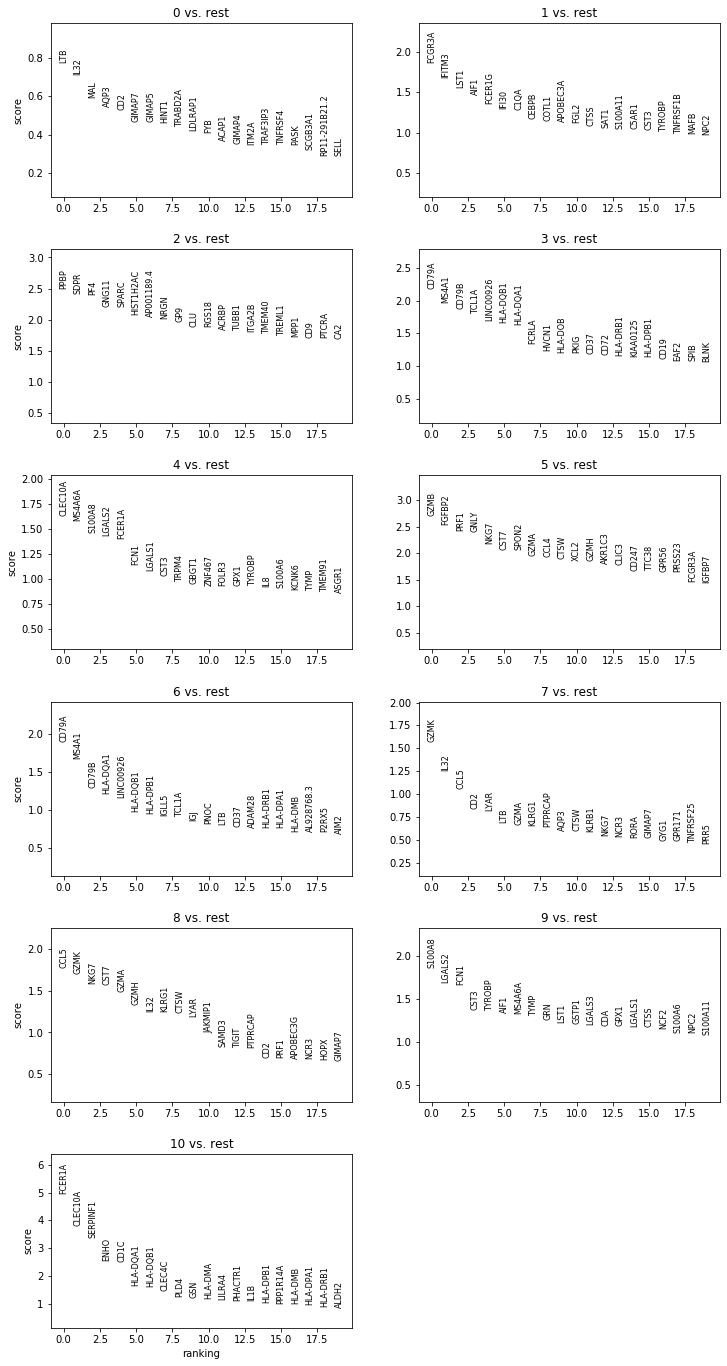

In [21]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, ncols=2, key='flat_gene_glm')

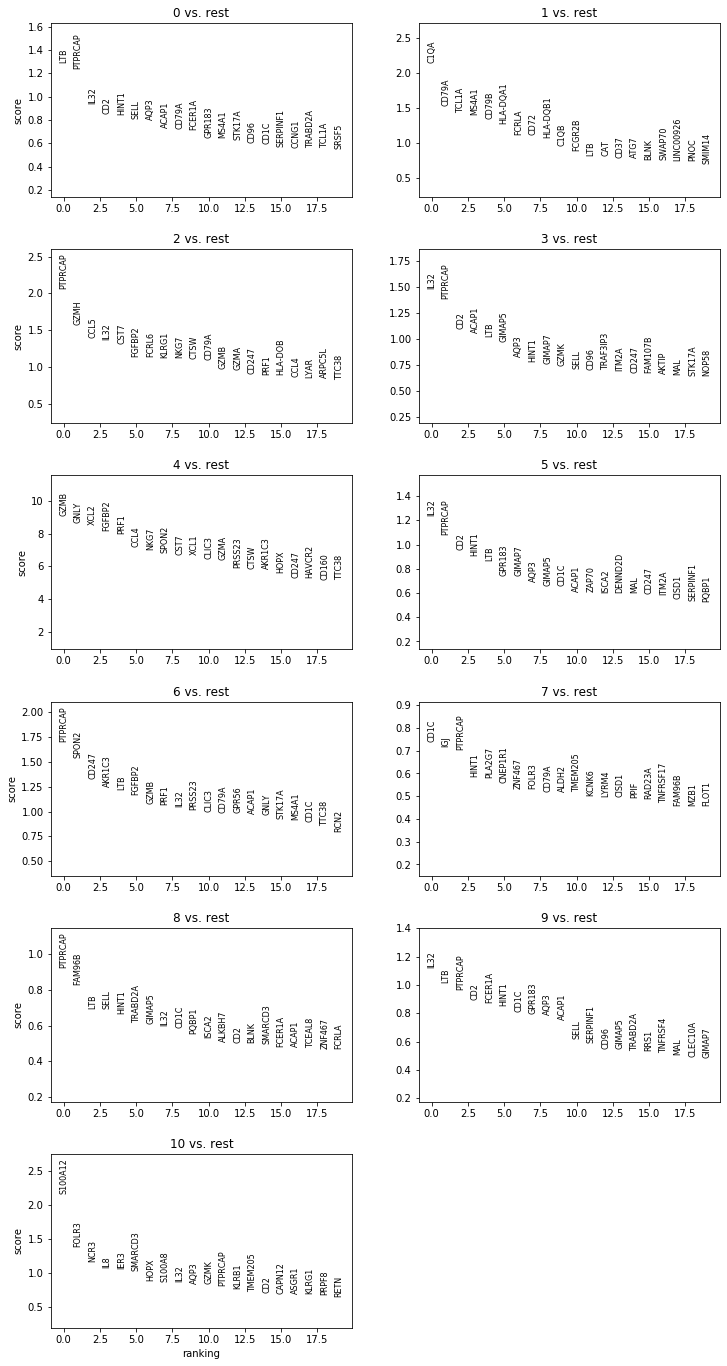

In [22]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, ncols=2, key='weight_gene_glm')

Of course, we can compare this genes to the ones that could be extracted from leiden grouping. For that we are using, again, the GLM in place of t-test

In [23]:
ldn_groups = sm.tools.categorical(data = adata.obs, col='leiden', drop=True) #convert to dummy variables
ldn_model = [sm.GLM(expr_values[:, x], sm.add_constant(ldn_groups)) for x in range(expr_values.shape[1])]
ldn_results = [x.fit() for x in ldn_model]
ldn_scores = np.array([x.params[1:] for x in ldn_results])
ldn_pvals = np.array([x.pvalues[1:] for x in ldn_results])
ldn_fdr = np.array([sm.stats.multipletests(ldn_pvals[:, x], method='fdr_bh')[1] for x in range(ldn_pvals.shape[1])]).T

In [24]:
gene_names = []
gene_scores = []
gene_pvalues = []
gene_fdr = []
gene_foldchange = []
for x in range(ldn_scores.shape[1]):
    up_mask = ldn_scores[:, x] > 0
    scores = ldn_scores[up_mask, x]
    pvals = ldn_pvals[up_mask, x]
    genes = np.array(adata.var_names)[up_mask]
    fdr = ldn_fdr[up_mask, x]
    selected = np.argsort(fdr)[:100]
    order = np.argsort(scores[selected])[::-1]
    gene_names.append(genes[selected][order])
    gene_scores.append(scores[selected][order])
    gene_pvalues.append(pvals[selected][order])
    gene_fdr.append(fdr[selected][order])
    gene_foldchange.append(scores[selected][order])

In [25]:
adata.uns['leiden_gene_glm'] = {
    'params': {'groupby': 'nsbm_level_2',
              'reference': 'rest',
              'method': 'GLM',
              'use_raw': False,
              'layer': None,
              'corr_method': 'benjamini-hochberg'},
    'scores': np.rec.fromarrays([n for n in gene_scores], dtype=[(rn, 'float32') for rn in adata.obs.leiden.cat.categories]),
    'logfoldchanges': np.rec.fromarrays([n for n in gene_scores], dtype=[(rn, 'float32') for rn in adata.obs.leiden.cat.categories]),    
    'pvals': np.rec.fromarrays([n for n in gene_pvalues], dtype=[(rn, 'float32') for rn in adata.obs.leiden.cat.categories]),    
    'pvals_adj': np.rec.fromarrays([n for n in gene_fdr], dtype=[(rn, 'float32') for rn in adata.obs.leiden.cat.categories]),        
    'names': np.rec.fromarrays([n for n in gene_names], dtype=[(rn, 'U50') for rn in adata.obs.leiden.cat.categories]),        
}

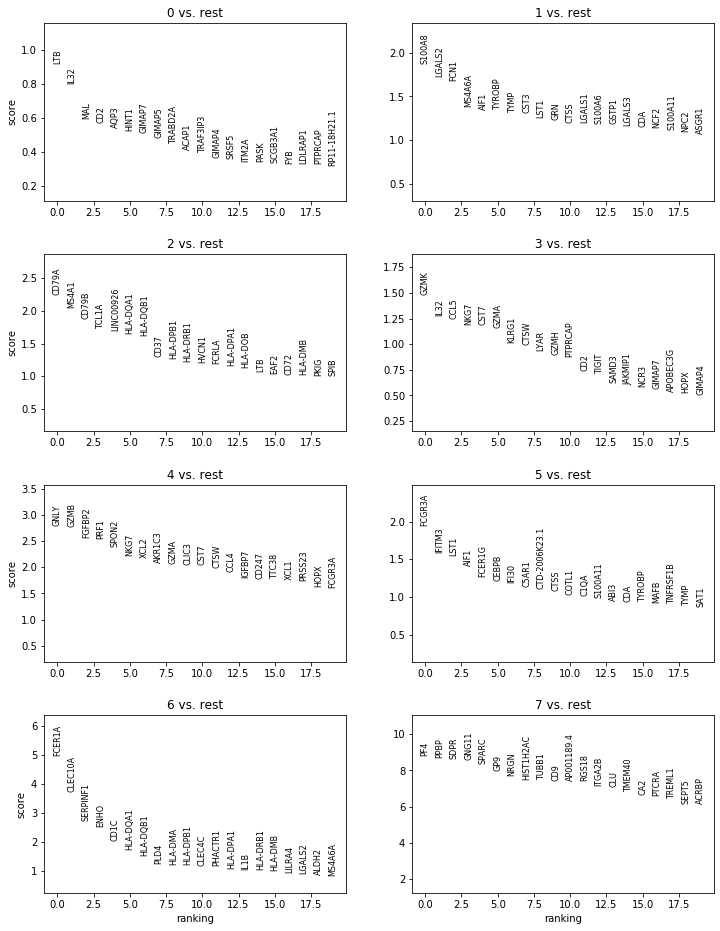

In [26]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, ncols=2, key='leiden_gene_glm')